In [17]:
from base_functions import * 


In [18]:
kodex200 = getCloseDataFdr("069500", "2010-01-10", "2022-10-10") # 코스피200 ETF
kodex5Bond = getCloseDataFdr("114470", "2010-01-10", "2022-10-10") 
print(kodex200, kodex5Bond)
#plt.figure()
#plt.plot(kodex200)

Date
2010-01-11    18239
2010-01-12    18259
2010-01-13    17963
2010-01-14    18174
2010-01-15    18259
              ...  
2022-09-30    28176
2022-10-04    28859
2022-10-05    28864
2022-10-06    29183
2022-10-07    29073
Name: Close, Length: 3145, dtype: int64 Date
2010-01-11     77454
2010-01-12     77490
2010-01-13     77582
2010-01-14     77577
2010-01-15     77594
               ...  
2022-09-30    105440
2022-10-04    106070
2022-10-05    105955
2022-10-06    105920
2022-10-07    105520
Name: Close, Length: 3145, dtype: int64


In [19]:
def getWeightByAvg(closeDataSet, n = 10):
    priceOnRebalDate = closeDataSet.loc[getRebalancingDate(closeDataSet)] # 리밸런싱 일자의 가격 데이터
    avg = priceOnRebalDate.copy()
    
    # 1 ~ n개월 모멘텀 스코어 합
    for i in range(1, n+1):
        avg += priceOnRebalDate.shift(i).fillna(method="bfill")
    avg = avg / n

    pd.set_option("display.max_rows", 10)
    weight = pd.DataFrame([], index=priceOnRebalDate.index)
    weight["kodex200"] = np.where(priceOnRebalDate > avg, 1, 0)
    weight["kodex5Bond"] = np.where(priceOnRebalDate > avg, 0, 1)
    return weight

weight = getWeightByAvg(kodex200)
print(weight)

            kodex200  kodex5Bond
Date                            
2010-01-29         0           1
2010-02-26         0           1
2010-03-31         0           1
2010-04-30         0           1
2010-05-31         0           1
...              ...         ...
2022-06-30         0           1
2022-07-29         0           1
2022-08-31         0           1
2022-09-30         0           1
2022-10-07         0           1

[154 rows x 2 columns]


In [20]:
def getRebalancingPortfolio(closeDataSet, period="month", weightDf=None, rebalDate=None):
    rebalancingDate = getRebalancingDate(closeDataSet, period)
    portfolio = pd.DataFrame()

    totalAsset = 1
    start = rebalancingDate[0]
    for end in rebalancingDate[1:]:
        weight = weightDf.loc[start]
        priceData = closeDataSet.loc[start:end]
        cumRet = getCumulativeReturn(priceData)
        weightCumRet = weight * cumRet
        netCumRet = totalAsset * weightCumRet

        start = end
        totalAsset = netCumRet.iloc[-1].sum()
        portfolio = pd.concat([portfolio, netCumRet])

    portfolio = portfolio.loc[~portfolio.index.duplicated(keep="last")]
    portfolioCumulativeReturn = portfolio.sum(axis=1)
    portfolioDayReturn = (portfolioCumulativeReturn / portfolioCumulativeReturn.shift(1))

    return portfolioDayReturn, portfolioCumulativeReturn
    

closeData = pd.concat([kodex200, kodex5Bond], axis=1)
closeData.dropna(inplace=True)
closeData.columns = ["kodex200", "kodex5Bond"]
print(closeData)
dayRet, cumRet = getRebalancingPortfolio(closeData, weightDf=weight)


            kodex200  kodex5Bond
Date                            
2010-01-11     18239       77454
2010-01-12     18259       77490
2010-01-13     17963       77582
2010-01-14     18174       77577
2010-01-15     18259       77594
...              ...         ...
2022-09-30     28176      105440
2022-10-04     28859      106070
2022-10-05     28864      105955
2022-10-06     29183      105920
2022-10-07     29073      105520

[3145 rows x 2 columns]


return: 1.869811818167643 
 cagr: 1.0516610301060052 
 mdd: 11.740029399077892


<Figure size 640x480 with 0 Axes>

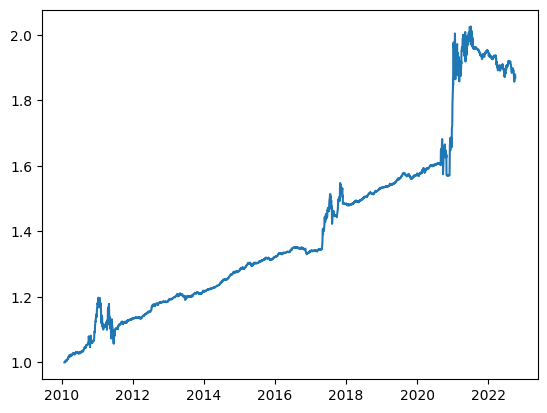

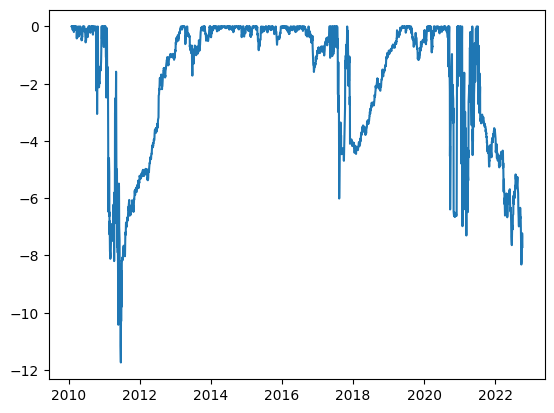

In [21]:
cagr, dd, mdd = getEval(cumRet)
plt.figure()
plt.subplots()
plt.plot(cumRet)
plt.subplots()
plt.plot(-dd)